In [1]:
import numpy as np
import pandas as pd

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "12"

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

2024-06-18 17:46:28.005287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from utils import (
    splitter,
    create_plot,
    forecast_accuracy
)

In [5]:
# Check everything with Tensorflow works 
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
# tf.keras.utils.set_random_seed(10)
# tf.config.experimental.enable_op_determinism()

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0

Python 3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [6]:
metrics_ = pd.DataFrame()

### Loading the Dataset

In [7]:
ts_prices_eth = pd.read_csv("Data/Time_Series/prices/ethereum_19_22.csv",index_col='date',parse_dates=['date'])

In [8]:
# crypto = 'crypto_bitcoin'
crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

### CryptoBERT

In [9]:
model ='CRYPTOBERT'
df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [10]:
ts_prices_eth= ts_prices_eth.join(df)

In [11]:
# Extracting some features from VADER sentiment time series
model ='VADER'
df_ = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])
ts_prices_eth= ts_prices_eth.join(df_[['total_stopwords','average_word_length']])

In [12]:
np.mean(df.neutral_count-df_.neutral_count)

-6.832991101984942

In [13]:
np.mean(df.positive_count-df_.positive_count)

5.488021902806297

In [14]:
np.mean(df.negative_count-df_.negative_count)

1.3449691991786448

In [15]:
# Remove Neutral Time Series
for c in ts_prices_eth.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_eth.drop(c,axis=1,inplace=True)

Dropping column neutral_count


In [16]:
ts_prices_eth.head(4) #.shape

,price,positive_count,negative_count,total_posts,total_words,total_comments,total_stopwords,average_word_length
date,,,,,,,,
2019-01-01,131.46,16,3,37,2068,750,838,6.196416
2019-01-02,138.14,21,4,81,3005,1502,1137,6.615711
2019-01-03,152.86,26,7,87,3850,1192,1446,6.966658
2019-01-04,146.73,19,3,63,1805,1293,675,6.364462


In [17]:
df = ts_prices_eth

### Adding Features

In [18]:
df.head()

,price,positive_count,negative_count,total_posts,total_words,total_comments,total_stopwords,average_word_length
date,,,,,,,,
2019-01-01,131.46,16,3,37,2068,750,838,6.196416
2019-01-02,138.14,21,4,81,3005,1502,1137,6.615711
2019-01-03,152.86,26,7,87,3850,1192,1446,6.966658
2019-01-04,146.73,19,3,63,1805,1293,675,6.364462
2019-01-05,153.06,30,2,71,2634,1053,995,6.545905


In [19]:
n_lags = 14
for lag in range(1, n_lags + 1):
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

In [20]:
window_sizes = [7, 14, 30]  # Window sizes for moving averages
for window_size in window_sizes:
    df[f'price_ma_{window_size}'] = df['price_lag_1'].rolling(window=window_size).mean()

In [21]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [22]:
df.isna().sum()

price                   0
positive_count          0
negative_count          0
total_posts             0
total_words             0
total_comments          0
total_stopwords         0
average_word_length     0
price_lag_1             1
price_lag_2             2
price_lag_3             3
price_lag_4             4
price_lag_5             5
price_lag_6             6
price_lag_7             7
price_lag_8             8
price_lag_9             9
price_lag_10           10
price_lag_11           11
price_lag_12           12
price_lag_13           13
price_lag_14           14
price_ma_7              7
price_ma_14            14
price_ma_30            30
day_of_week             0
month                   0
year                    0
dtype: int64

In [23]:
df = df[30:]

In [24]:
test_split=round(len(df)*0.40)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
val_split=round(len(df_for_testing)*0.50)
df_for_validation=df_for_testing[:-val_split]
df_for_testing=df[-val_split:]
print(f"Training Set: {df_for_training.shape}")
print(f"Validation Set: {df_for_validation.shape}")
print(f"Testing Set: {df_for_testing.shape}")

Training Set: (859, 28)
Validation Set: (286, 28)
Testing Set: (286, 28)


In [25]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled.shape, df_for_validation_scaled.shape

((859, 28), (286, 28))

In [26]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
valX,valY=createXY(df_for_validation_scaled,30)

In [27]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(30,return_sequences=True,input_shape=(30,27)))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))
parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/var/folders/2l/h6ht9_t96fn33pfzbxcdp_dm0000gn/T/ipykernel_8516/1645025208.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))


In [28]:
grid_search = grid_search.fit(trainX,trainY)

2024-06-18 17:46:32.156888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 17:46:32.157006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-06-18 17:46:32.845738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:32.847401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:32.848561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:46:33.690440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:33.693175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:33.694644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0545

2024-06-18 17:46:41.392992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:41.394529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:41.395587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 9s 116ms/step - loss: 0.0545 - val_loss: 0.0632
Epoch 2/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0068 - val_loss: 0.0458
Epoch 3/8
26/26 [==============================] - 1s 52ms/step - loss: 0.0062 - val_loss: 0.0385
Epoch 4/8
26/26 [==============================] - 1s 39ms/step - loss: 0.0055 - val_loss: 0.0419
Epoch 5/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0044 - val_loss: 0.0428
Epoch 6/8
26/26 [==============================] - 1s 39ms/step - loss: 0.0045 - val_loss: 0.0443
Epoch 7/8
26/26 [==============================] - 1s 41ms/step - loss: 0.0037 - val_loss: 0.0546
Epoch 8/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0037 - val_loss: 0.0464


2024-06-18 17:46:49.903430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:49.905269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:49.906446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 16ms/step - loss: 0.0011


2024-06-18 17:46:51.289116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:51.290827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:51.291985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:46:51.763062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:51.764740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:51.766093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0016

2024-06-18 17:46:57.979976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:57.981574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:57.982861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 8s 115ms/step - loss: 0.0016 - val_loss: 0.4099
Epoch 2/8
26/26 [==============================] - 1s 52ms/step - loss: 2.8181e-04 - val_loss: 0.3111
Epoch 3/8
26/26 [==============================] - 2s 59ms/step - loss: 1.4214e-04 - val_loss: 0.2609
Epoch 4/8
26/26 [==============================] - 1s 44ms/step - loss: 1.3755e-04 - val_loss: 0.2344
Epoch 5/8
26/26 [==============================] - 1s 43ms/step - loss: 1.0892e-04 - val_loss: 0.2220
Epoch 6/8
26/26 [==============================] - 1s 43ms/step - loss: 8.6465e-05 - val_loss: 0.2190
Epoch 7/8
26/26 [==============================] - 1s 43ms/step - loss: 8.5950e-05 - val_loss: 0.2158
Epoch 8/8
26/26 [==============================] - 1s 45ms/step - loss: 8.7311e-05 - val_loss: 0.2251


2024-06-18 17:47:08.064516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:08.066712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:08.068289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 20ms/step - loss: 0.0271


2024-06-18 17:47:10.293748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:10.296593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:10.298241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:47:10.833631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:10.836469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:10.838333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0131

2024-06-18 17:47:16.360407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:16.362095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:16.363245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 6s 87ms/step - loss: 0.0131 - val_loss: 0.1281
Epoch 2/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0050 - val_loss: 0.0451
Epoch 3/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0059 - val_loss: 0.0749
Epoch 4/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0041 - val_loss: 0.0717
Epoch 5/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0040 - val_loss: 0.1182
Epoch 6/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0041 - val_loss: 0.1113
Epoch 7/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0027 - val_loss: 0.1183
Epoch 8/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0034 - val_loss: 0.1038
Epoch 9/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0022 - val_loss: 0.1358
Epoch 10/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0023 - val_loss: 0.1337


2024-06-18 17:47:26.153247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:26.154696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:26.155797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 14ms/step - loss: 2.1289e-04


2024-06-18 17:47:27.470516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:27.472121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:27.473315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:47:28.314312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:28.315970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:28.317245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0017

2024-06-18 17:47:33.084770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:33.086210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:33.087410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 6s 89ms/step - loss: 0.0017 - val_loss: 0.6603
Epoch 2/10
26/26 [==============================] - 1s 38ms/step - loss: 4.2270e-04 - val_loss: 0.4562
Epoch 3/10
26/26 [==============================] - 1s 55ms/step - loss: 2.1154e-04 - val_loss: 0.3600
Epoch 4/10
26/26 [==============================] - 2s 60ms/step - loss: 1.5735e-04 - val_loss: 0.2899
Epoch 5/10
26/26 [==============================] - 2s 76ms/step - loss: 1.2527e-04 - val_loss: 0.2970
Epoch 6/10
26/26 [==============================] - 1s 55ms/step - loss: 1.1832e-04 - val_loss: 0.3106
Epoch 7/10
26/26 [==============================] - 1s 50ms/step - loss: 9.1246e-05 - val_loss: 0.3122
Epoch 8/10
26/26 [==============================] - 1s 38ms/step - loss: 8.3338e-05 - val_loss: 0.3030
Epoch 9/10
26/26 [==============================] - 1s 40ms/step - loss: 7.0268e-05 - val_loss: 0.3048
Epoch 10/10
26/26 [==============================] - 1s 41ms/step - loss: 6.7121e-05 - v

2024-06-18 17:47:46.004446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:46.006289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:46.007717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 15ms/step - loss: 0.0308


2024-06-18 17:47:47.436006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:47.437367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:47.438631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:47:47.642837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:47.645678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:47.646945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0223

2024-06-18 17:47:53.188851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:53.190599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:53.192272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 7s 135ms/step - loss: 0.0223 - val_loss: 0.0828
Epoch 2/8
21/21 [==============================] - 1s 44ms/step - loss: 0.0070 - val_loss: 0.0468
Epoch 3/8
21/21 [==============================] - 1s 43ms/step - loss: 0.0042 - val_loss: 0.0468
Epoch 4/8
21/21 [==============================] - 1s 43ms/step - loss: 0.0044 - val_loss: 0.0455
Epoch 5/8
21/21 [==============================] - 1s 47ms/step - loss: 0.0047 - val_loss: 0.0541
Epoch 6/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0040 - val_loss: 0.0512
Epoch 7/8
21/21 [==============================] - 1s 56ms/step - loss: 0.0038 - val_loss: 0.0541
Epoch 8/8
21/21 [==============================] - 0s 17ms/step - loss: 0.0023


2024-06-18 17:48:01.869893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:01.871873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:01.873256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:48:02.861112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:02.862835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:02.864139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0026

2024-06-18 17:48:08.707586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:08.709347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:08.710446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 7s 120ms/step - loss: 0.0026 - val_loss: 0.4526
Epoch 2/8
21/21 [==============================] - 1s 45ms/step - loss: 4.1098e-04 - val_loss: 0.3378
Epoch 3/8
21/21 [==============================] - 1s 43ms/step - loss: 1.8707e-04 - val_loss: 0.2853
Epoch 4/8
21/21 [==============================] - 1s 42ms/step - loss: 1.5798e-04 - val_loss: 0.2503
Epoch 5/8
21/21 [==============================] - 1s 58ms/step - loss: 1.4475e-04 - val_loss: 0.2386
Epoch 6/8
21/21 [==============================] - 1s 43ms/step - loss: 1.0731e-04 - val_loss: 0.2318
Epoch 7/8
21/21 [==============================] - 1s 42ms/step - loss: 1.1841e-04 - val_loss: 0.2388
Epoch 8/8
21/21 [==============================] - 0s 16ms/step - loss: 0.0286


2024-06-18 17:48:17.101308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:17.102948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:17.104211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:48:17.571927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:17.573759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:17.575006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0143

2024-06-18 17:48:23.626281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:23.627712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:23.628848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 7s 132ms/step - loss: 0.0143 - val_loss: 0.0867
Epoch 2/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0058 - val_loss: 0.0871
Epoch 3/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0061 - val_loss: 0.0596
Epoch 4/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0043 - val_loss: 0.0744
Epoch 5/10
21/21 [==============================] - 1s 45ms/step - loss: 0.0034 - val_loss: 0.0711
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0033 - val_loss: 0.0969
Epoch 7/10
21/21 [==============================] - 1s 50ms/step - loss: 0.0028 - val_loss: 0.1322
Epoch 8/10
21/21 [==============================] - 1s 48ms/step - loss: 0.0025 - val_loss: 0.1098
Epoch 9/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0027 - val_loss: 0.1140
Epoch 10/10
21/21 [==============================] - 0s 19ms/step - loss: 0.0021


2024-06-18 17:48:33.971881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:33.974128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:33.975726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:48:35.365684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:35.367539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:35.368796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0020

2024-06-18 17:48:43.359914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:43.368771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:43.373194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 13s 295ms/step - loss: 0.0020 - val_loss: 0.5640
Epoch 2/10
21/21 [==============================] - 1s 57ms/step - loss: 4.4214e-04 - val_loss: 0.4027
Epoch 3/10
21/21 [==============================] - 1s 55ms/step - loss: 2.1730e-04 - val_loss: 0.3245
Epoch 4/10
21/21 [==============================] - 1s 42ms/step - loss: 1.4603e-04 - val_loss: 0.2891
Epoch 5/10
21/21 [==============================] - 1s 43ms/step - loss: 1.2450e-04 - val_loss: 0.2564
Epoch 6/10
21/21 [==============================] - 1s 46ms/step - loss: 1.0071e-04 - val_loss: 0.2493
Epoch 7/10
21/21 [==============================] - 1s 67ms/step - loss: 7.8898e-05 - val_loss: 0.2512
Epoch 8/10
21/21 [==============================] - 1s 44ms/step - loss: 7.7663e-05 - val_loss: 0.2476
Epoch 9/10
21/21 [==============================] - 1s 57ms/step - loss: 6.7730e-05 - val_loss: 0.2517
Epoch 10/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0255


2024-06-18 17:48:57.249295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:57.250881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:57.252143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:48:57.738818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:48:57.740564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:48:57.741856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - ETA: 0s - loss: 0.0101

2024-06-18 17:49:03.508315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:49:03.509853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:49:03.510943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 7s 78ms/step - loss: 0.0101 - val_loss: 0.0575
Epoch 2/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0031 - val_loss: 0.0390
Epoch 3/10
42/42 [==============================] - 2s 45ms/step - loss: 0.0023 - val_loss: 0.0389
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0022 - val_loss: 0.0304
Epoch 5/10
42/42 [==============================] - 2s 43ms/step - loss: 0.0031 - val_loss: 0.0717
Epoch 6/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0019 - val_loss: 0.0433
Epoch 7/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0021 - val_loss: 0.0635
Epoch 8/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0016 - val_loss: 0.0530
Epoch 9/10
42/42 [==============================] - 2s 37ms/step - loss: 0.0011 - val_loss: 0.0740
Epoch 10/10
42/42 [==============================] - 2s 36ms/step - loss: 0.0011 - val_loss: 0.0398


In [29]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}

In [30]:
my_model_all=grid_search.best_estimator_.model

In [31]:
my_model_all.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 30)            6960      
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 14,311
Trainable params: 14,311
Non-trainable params: 0
_________________________________________________________________


In [32]:
df.shape

(1431, 28)

In [33]:
df_for_validation[-30:].shape, df_for_validation[-30:].index[0]

((30, 28), Timestamp('2022-02-19 00:00:00'))

In [34]:
df_for_testing = pd.concat([df_for_validation[-30:],df_for_testing])

In [35]:
df_for_testing.shape

(316, 28)

In [36]:
df_for_testing_scaled = scaler.transform(df_for_testing)
testX,testY=createXY(df_for_testing_scaled,30)
pred = my_model_all.predict(testX)
prediction_copies_array = np.repeat(pred,28, axis=-1)
predicted_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(pred),28)))[:,0]

2024-06-18 17:49:19.976398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:49:19.977674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:49:19.979229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 1s 25ms/step


In [37]:
predicted_prices.shape

(286,)

In [38]:
df_for_testing[30:].shape

(286, 28)

In [39]:
n_df= pd.DataFrame()
n_df.index = df_for_testing.index[30:]
n_df['price'] = predicted_prices

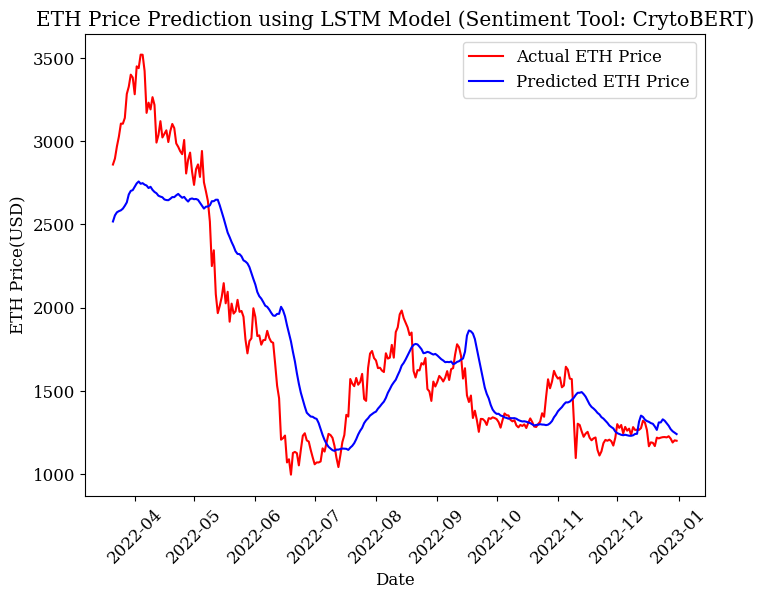

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(df_for_testing['price'].iloc[30:], color = 'red', label = 'Actual ETH Price')
plt.plot(n_df['price'], color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction using LSTM Model (Sentiment Tool: CrytoBERT)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('ETH Price(USD)')
plt.legend()
plt.show()

In [50]:
res = forecast_accuracy(n_df['price'], df_for_testing['price'].iloc[30:],['ETH_ModelD'])
res

,MAE,MAPE,MSE,RMSE
ETH_ModelD,237.424785,13.736365,92570.644872,304.254244


In [51]:
my_model_all.save("ETH_ModelD.keras")